In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from pyod.models.pca import PCA

In [2]:
#!pip install pyod
#!pip install combo

In [3]:
# Clean data inladen
freezer = pd.read_csv('freezerdata_clean 15-03 tm 19-03.csv', index_col= 0, sep = ',')
freezer['Date'] = pd.to_datetime(freezer['Date'])
freezer.set_index('Date', inplace= True)
freezer['timeDeltaMins'] = (freezer.index - freezer.index[0]).total_seconds() / 60
freezer['timeDeltaMins'].fillna(0, inplace=True)

freezer = freezer.interpolate(method= 'linear', limit_direction= 'forward', axis= 0)
freezer = freezer.copy()[1:]

C:\Users\chaos\AppData\Local\Temp\ipykernel_20640\2806207593.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  freezer['timeDeltaMins'].fillna(0, inplace=True)


In [4]:
# Data met outliers inladen
outliers = pd.read_csv('freezerdata_clean_outliers.csv', index_col= 0)
outliers['Date'] = pd.to_datetime(outliers['Date'])
outliers.set_index('Date', inplace= True)
outliers = outliers.sort_index(ascending=True)
outliers['timeDeltaMins'] = (outliers.index - outliers.index[0]).total_seconds() / 60
outliers['timeDeltaMins'].fillna(0, inplace=True)

outliers = outliers.interpolate(method= 'linear', limit_direction= 'forward', axis= 0)
outliers = outliers.copy()[1:]

C:\Users\chaos\AppData\Local\Temp\ipykernel_20640\800955072.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outliers['timeDeltaMins'].fillna(0, inplace=True)


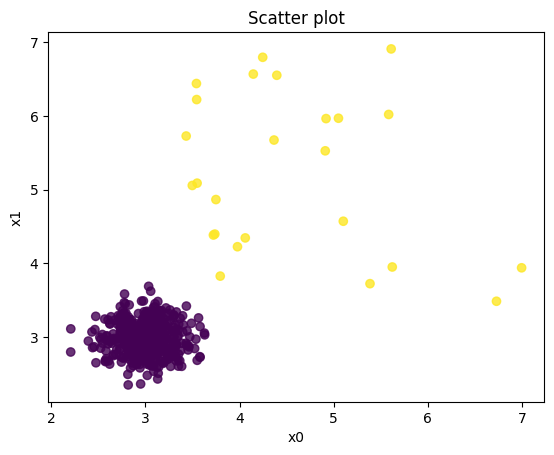

In [6]:
# Test met generate data
from pyod.utils.data import generate_data
contamination = 0.05
n_train = 500
n_test = 500
n_features = 6
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [7]:
color_map = {'False Positive': 'red', 'True Positive': 'green', 'False Negative': 'orange', 'True Negative': 'lime'}
def classify_prediction(row):
    if row['Outlier'] == 1 and row['Actual'] == 1:
        return 'True Positive'
    elif row['Outlier'] == 1 and row['Actual'] == 0:
        return 'False Positive'
    elif row['Outlier'] == 0 and row['Actual'] == 1:
        return 'False Negative'
    else:
        return 'True Negative'

## Time series: Outliers visualisatie over de tijd op variabel 'Refrigerated'

In [8]:
outliers['OutlierLabel'] = outliers['Outlier'].map({0: 'Inlier', 1: 'Outlier'})

fig = px.scatter(
    outliers,
    x=outliers.index,
    y='Refrigerated',
    color='OutlierLabel',
    color_discrete_map={'Inlier': 'blue', 'Outlier': 'red'},
    labels={'x': 'Date', 'Refrigerated': 'Refrigerated Value'},
    title='Outliers visualisatie'
)

for ts in outliers[outliers['Outlier'] == 1].index:
    fig.add_vrect(
        x0=ts - pd.Timedelta(minutes=1),
        x1=ts + pd.Timedelta(minutes=1),
        fillcolor="red",
        opacity=0.2,
        line_width=0,
        layer="below"
    )

fig.update_layout(
    plot_bgcolor='black',  
    paper_bgcolor='black',
    font_color='white',     
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='white',
    zeroline=False
)

fig.update_yaxes(
    showgrid=True,
    gridcolor='white',
    zeroline=False
)
fig.show()

## Confusion Matrix voor baseline model (1,5 x IQR methode)

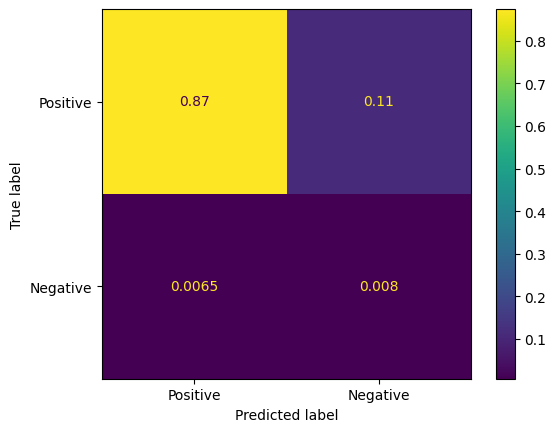

In [9]:
# Baseline model
freezer_copy = freezer.copy()


Q1 = freezer_copy['Refrigerated'].quantile(0.25)
Q3 = freezer_copy['Refrigerated'].quantile(0.75)
iqr = Q3 - Q1
lower = Q1 - (1.5*iqr)
upper = Q3 + (1.5*iqr)

freezer_copy['Outlier'] = np.where(freezer_copy['Refrigerated'] < lower, 1, np.where(freezer_copy['Refrigerated'] > upper, 1, 0))

# Confusion matrix voor baseline model
y_true = outliers['Outlier']
y_pred = freezer_copy['Outlier']

cm = confusion_matrix(y_true, y_pred, normalize='all')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot()

In [10]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.0676
Recall:    0.5545
F1 Score:  0.1204


In [11]:
true_outliers = outliers['Outlier'].copy()
freezer_copy['Actual'] = true_outliers

freezer_copy['Prediction'] = freezer_copy.apply(classify_prediction, axis=1)

In [12]:

fig = px.scatter(
    freezer_copy,
    x=freezer_copy.index,
    y='Refrigerated',
    color='Prediction',
    color_discrete_map=color_map,
    labels={'x': 'Date', 'Refrigerated': 'Refrigerated Value'},
    title='Visualisatie voorspelling met baseline model (1,5 x IQR methode)'
)

fig.update_layout(
    plot_bgcolor='black',  
    paper_bgcolor='black',
    font_color='white',     
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='white',
    zeroline=False
)

fig.update_yaxes(
    showgrid=True,
    gridcolor='white',
    zeroline=False
)
fig.show()

* True Negative: Voorspelling = 0, Actueel = 0
* False Negative: Voorspelling 0, Actueel 1
* True Positive: Voorspelling = 1, Actueel = 1
* False Positive: Voorspelling = 1, Actueel = 0

# PCA (2D model)

In [23]:
df_diff = freezer.diff()[1:]
df_diff

,Door,EnergyKWh,Environment,HotGasPipe,LiquidPipe,Refrigerated,SuctionPipe,Time,timeDeltaMins
Date,,,,,,,,,
2023-03-14 23:02:00,0.0,0.0,0.00,0.0,0.2,0.2,0.10,1.0,1.0
2023-03-14 23:03:00,0.0,0.0,0.00,0.0,-0.1,-0.2,-0.20,1.0,1.0
2023-03-14 23:04:00,0.0,0.0,0.00,0.0,0.0,0.1,0.10,1.0,1.0
2023-03-14 23:05:00,0.0,0.0,-0.10,0.0,0.0,0.1,-0.10,1.0,1.0
2023-03-14 23:06:00,0.0,0.0,0.10,-0.1,0.1,-0.1,0.10,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2023-03-19 18:56:00,0.0,0.0,0.05,6.5,1.6,-2.4,-3.05,1.0,1.0
2023-03-19 18:57:00,0.0,0.0,0.05,9.6,2.1,1.3,-3.05,1.0,1.0
2023-03-19 18:58:00,0.0,0.0,0.10,1.2,-0.5,0.2,-0.60,1.0,1.0


In [13]:
X_train_pd = outliers.loc[:, ['Door', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']]
X_train = X_train_pd.to_numpy()

y_train = outliers.loc[:, 'Outlier']
y_train.value_counts()

X_test_pd = X_train_pd.copy()
X_test = X_test_pd.to_numpy()

pca = PCA(contamination = 0.05)
pca.fit(X_train)

PCA(contamination=0.05, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

## Confusion Matrix voor data van de eerste 50 uur

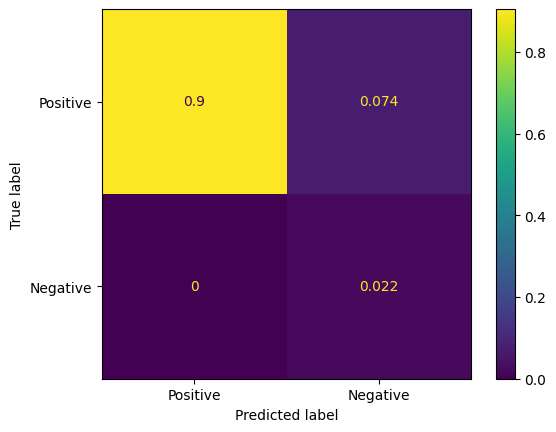

In [14]:
freezer3000 = freezer.loc[freezer['timeDeltaMins'] <= 3000].copy()
X_freezer3000 = freezer3000.loc[:, ['Door', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']]

freezer3000['Outlier'] = pca.predict(X_freezer3000)
y_true = outliers[outliers.index.isin(freezer3000.index)]['Outlier']
y_pred = freezer3000['Outlier']

cm = confusion_matrix(y_true, y_pred, normalize='all')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot()

In [15]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.2300
Recall:    1.0000
F1 Score:  0.3739


In [16]:
true_outliers = outliers.loc[outliers['timeDeltaMins'] <= 3000].copy()['Outlier']
freezer3000['Actual'] = true_outliers
freezer3000['Prediction'] = freezer3000.apply(classify_prediction, axis=1)

In [24]:
fig = px.scatter(
    freezer3000,
    x=freezer3000.index,
    y='Refrigerated',
    color='Prediction',
    color_discrete_map=color_map,
    labels={'x': 'Date', 'Refrigerated': 'Refrigerated Value'},
    title='Visualisatie voorspelling met PCA'
)

for ts in freezer3000[(freezer3000['Prediction'] == 'False Positive') | (freezer3000['Prediction'] == 'False Negative')].index:
    fig.add_vrect(
        x0=ts - pd.Timedelta(minutes=1),
        x1=ts + pd.Timedelta(minutes=1),
        fillcolor="red",
        opacity=0.2,
        line_width=0,
        layer="below"
    )

fig.update_layout(
    plot_bgcolor='black',  
    paper_bgcolor='black',
    font_color='white',     
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='white',
    zeroline=False
)

fig.update_yaxes(
    showgrid=True,
    gridcolor='white',
    zeroline=False
)
fig.show()

In [20]:
X = freezer[['Door', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']]
y_true = outliers['Outlier']

contaminations = np.arange(0.01, 0.2, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []
for c in contaminations:
    clf = PCA(contamination=c)
    clf.fit(X)
    
    y_pred = clf.predict(X)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)


# Conclusie
* Wat is de beste waarde van contamination?

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=contaminations,
    y=precision_scores,
    mode='lines+markers',
    name='Precision',
    line=dict(color='royalblue')
))

fig.add_trace(go.Scatter(
    x=contaminations,
    y=recall_scores,
    mode='lines+markers',
    name='Recall',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=contaminations,
    y=f1_scores,
    mode='lines+markers',
    name='F1 Score',
    line=dict(color='green')
))

fig.update_layout(
    title="Precision, Recall & F1 Score vs Contamination",
    xaxis_title="Contamination",
    yaxis_title="Score",
    yaxis=dict(range=[0, 1.05]),
    template='plotly_dark',
    width=800,
    height=500
)
fig.add_hline(
    y=np.max(f1_scores),
    line_dash="dot",
    annotation_text=f"Hoogste F1 Score: {round(np.max(f1_scores), 2)}", 
    annotation_position="bottom right"
)
fig.show()